In [1]:
#default_exp callbacks

In [2]:
#export
from fastai.vision import *
from fastai.callbacks import *
from time import time
from fastprogress.fastprogress import format_time

### `TerminateOnNaNCallback`

In [3]:
#export
class TerminateOnNaNCallback(Callback):
    "A `Callback` that terminates training if loss is NaN."

    def __init__(self):
        self.stop = False
        self.isnan = False
        
    def on_batch_end(self, last_loss, epoch, num_batch, **kwargs:Any)->None:
        "Test if `last_loss` is NaN and interrupts training."
        if self.stop: return True #to skip validation after stopping during training
        if torch.isnan(last_loss):
            print (f'Epoch/Batch ({epoch}/{num_batch}): Invalid loss, terminating training.')
            self.isnan = True
            return {'stop_epoch': True, 'stop_training': True, 'skip_validate': True}

### `SaveDistributedModelCallback`

In [4]:
#export
class SaveDistributedModelCallback(TrackerCallback):
    "SaveModelCallback modified for distributed transfer learning - remove torch.load"
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement',
                 name:str='bestmodel', gpu=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        self.gpu = gpu
      
    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        if not hasattr(self, 'best'):
            print("Initializing self.best")
            self.best = float('inf') if self.operator == np.less else -float('inf')
        
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: 
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                if not self.gpu: print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')

### `CSVDistributedLogger`

In [5]:
#export
class CSVDistributedLogger(LearnerCallback):
    "CSVLogger modified for distributed transfer learning - only write with gpu:0"
    def __init__(self, learn:Learner, filename: str = 'history', append: bool = False, gpu: int = None): 
        super().__init__(learn)
        self.filename,self.path,self.append = filename,self.learn.path/f'{filename}.csv',append
        self.add_time = True
        self.gpu = gpu

    def read_logged_file(self):  
        "Read the content of saved file"
        return pd.read_csv(self.path)

    def on_train_begin(self, **kwargs: Any) -> None:
        "Prepare file with metric names."
        self.path.parent.mkdir(parents=True, exist_ok=True)      
        self.file = self.path.open('a') if self.append else self.path.open('w')
        if not self.gpu: self.file.write(','.join(self.learn.recorder.names[:(None if self.add_time else -1)]) + '\n')
    
    def on_epoch_begin(self, **kwargs:Any)->None:
        if self.add_time: self.start_epoch = time()
        
    def on_epoch_end(self, epoch: int, smooth_loss: Tensor, last_metrics: MetricsList, **kwargs: Any) -> bool:
        "Add a line with `epoch` number, `smooth_loss` and `last_metrics`."
        last_metrics = ifnone(last_metrics, [])
        stats = [str(stat) if isinstance(stat, int) else '#na#' if stat is None else f'{stat:.6f}'
                 for name, stat in zip(self.learn.recorder.names, [epoch, smooth_loss] + last_metrics)]
        if self.add_time: stats.append(format_time(time() - self.start_epoch))
        str_stats = ','.join(stats)
        if not self.gpu: self.file.write(str_stats + '\n')
        self.file.flush()
        os.fsync(self.file.fileno())

    def on_train_end(self, **kwargs: Any) -> None:  
        "Close the file."
        self.file.close()

### `tests`

In [28]:
from local.segmentation.dataset import SemanticSegmentationData
from local.segmentation.metrics import *
# from local.segmentation.losses_binary import *
from local.segmentation.losses_multilabel import *
# test data creation
PATH = Path("/home/turgutluk/.fastai/data/camvid")
IMAGES = "images"
MASKS = "labels"
CODES = "codes.txt"
TRAIN, VALID, TEST = "train.txt", "valid.txt", "test.txt"
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN,
                                  VALID, TEST, sample_size=None, bs=4, size=112)
data = ssdata.get_data()

In [29]:
learn = unet_learner(data, models.resnet34); learn.metrics = [partial(foreground_acc, void_code=30)]
learn.path = Path(".")

In [30]:
learn.loss_func = lovasz_softmax

In [31]:
#export
def _get_metric_name(f):
    try: return f.func.__name__
    except: return f.__name__

In [32]:
save_cb = SaveDistributedModelCallback(learn, monitor=_get_metric_name(learn.metrics[0]))
csvlog_cb = CSVLogger(learn, './history.csv', append=True)
nan_cb = TerminateOnNaNCallback()
cbs = [save_cb, csvlog_cb, nan_cb]

In [33]:
learn.fit_one_cycle(1, callbacks=cbs); nan_cb.isnan

Initializing self.best


epoch,train_loss,valid_loss,foreground_acc,time
0,0.818350,0.779612,0.655347,00:17


Better model found at epoch 0 with foreground_acc value: 0.6553472280502319.


False

In [34]:
learn.fit_one_cycle(1, max_lr=100, callbacks=cbs); nan_cb.isnan

epoch,train_loss,valid_loss,foreground_acc,time


Epoch/Batch (0/2): Invalid loss, terminating training.


True

In [35]:
os.remove(learn.csv_logger.path)

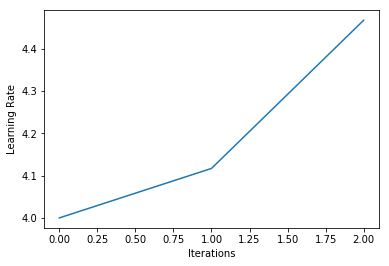

In [36]:
learn.recorder.plot_lr()

### export

In [37]:
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_script.ipynb.
Converted 02_scheduler.ipynb.
Converted 03_callbacks.ipynb.
Converted 10_segmentation_dataset.ipynb.
Converted 11_segmentation_losses_mulitlabel.ipynb.
Converted 11b_segmentation_losses_binary.ipynb.
Converted 12_segmentation_metrics.ipynb.
Converted 13_segmentation_models.ipynb.
Converted segmentation_training.ipynb.


### fin